# How to train a voc compatible dataset.
> Note: This notebook shows a special use case of training a VOC compatible dataset using the predefined [VOC parser](https://github.com/airctic/icevision/blob/master/icevision/parsers/voc_parser.py) without creating both data, and parsers files as opposed to the [fridge dataset](https://github.com/airctic/icevision/tree/master/icevision/datasets/fridge) example.

## Installing IceVision

We will install the IceVision latest version from its GitHub repo (master branch) 

In [ ]:
pip install git+git://github.com/airctic/icevision.git#egg=icevision[all] --upgrade
pip install omegaconf effdet@https://github.com/rwightman/efficientdet-pytorch/archive/master.zip#egg=effdet-0.1.4

## Clone the raccoom dataset repository

In [ ]:
!git clone https://github.com/datitran/raccoon_dataset

## Imports

In [3]:
from icevision.all import *

## WARNING: 
Make sure you have already cloned the raccoon dataset using the command shown here above
### Set images and annotations directories

In [4]:
data_dir = Path('raccoon_dataset')

images_dir = data_dir / 'images'
annotations_dir = data_dir / 'annotations'

### Define class_map

In [5]:
class_map = ClassMap(['raccoon'])

### Parser: Use icevision predefined VOC parser

In [6]:
parser = parsers.voc(annotations_dir=annotations_dir, images_dir=images_dir, class_map=class_map)

### train and validation records

In [ ]:
data_splitter = RandomSplitter((.8, .2))
train_records, valid_records = parser.parse(data_splitter)

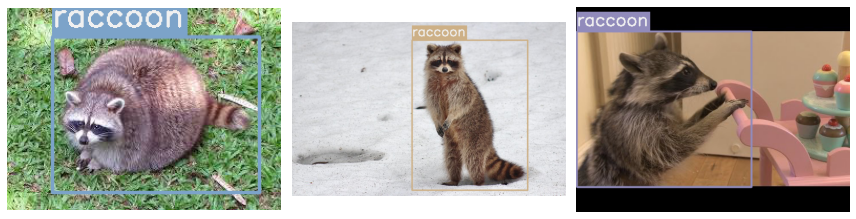

In [8]:
show_records(train_records[:3], ncols=3, class_map=class_map)

## Datasets
### Transforms

In [9]:
presize = 512
size = 384

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=size), tfms.A.Normalize()])

### Train and Validation Dataset Objects

In [10]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

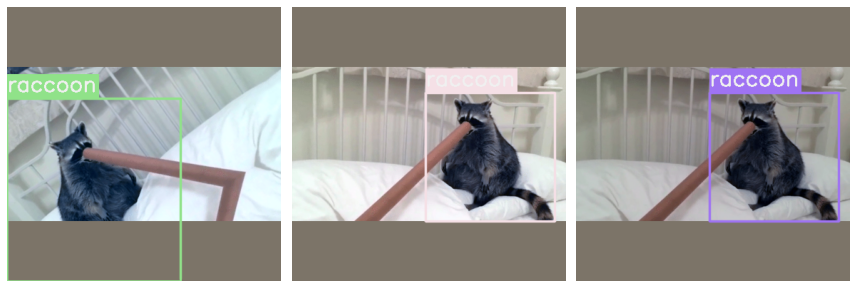

In [11]:
samples = [train_ds[5] for _ in range(3)]
show_samples(samples, class_map=class_map, denormalize_fn=denormalize_imagenet, ncols=3)

### DataLoaders

In [12]:
train_dl = efficientdet.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = efficientdet.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

### Model

In [ ]:
model = efficientdet.model('tf_efficientdet_lite0', num_classes=len(class_map), img_size=size)

### Fastai Learner

In [14]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [15]:
learn = efficientdet.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

## Fastai Training
### Learning Rate Finder

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.10000000149011612)

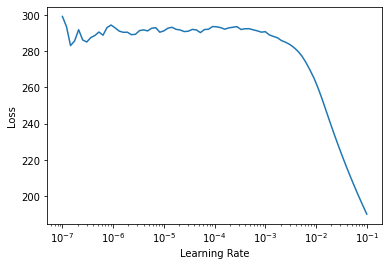

In [16]:
learn.freeze()
learn.lr_find()

### Fine tune: 2 Phases
- Phase 1: Train the head for 10 epochs while freezing the body
- Phase 2: Train both the body and the head during 50 epochs

In [ ]:
learn.fine_tune(50, 1e-2, freeze_epochs=10)

## Show results

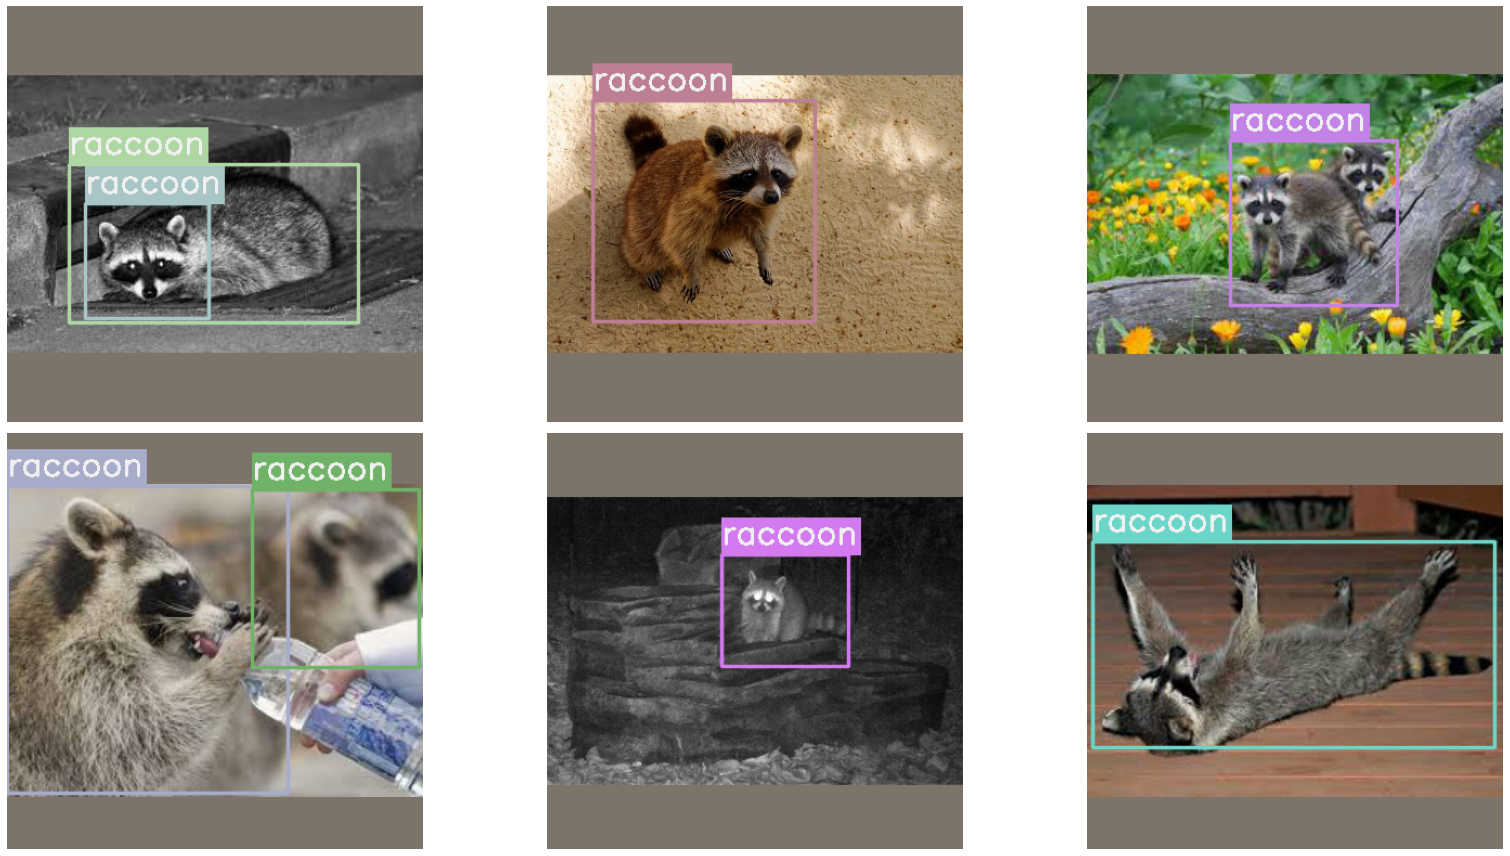

In [18]:
efficientdet.show_results(model, valid_ds, class_map=class_map)

> **Note:** You might train the model longer in order to increase its accuracy

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://spectrum.chat/mantis).